In [1]:
# импортируем необходимые библиотеки, классы и функции
import numpy as np
import pandas as pd
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (StandardScaler, 
                                   OneHotEncoder)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.ensemble import (GradientBoostingClassifier,
                              RandomForestClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import (calibration_curve, 
                                 CalibratedClassifierCV)
from sklearn.metrics import (brier_score_loss, 
                             roc_auc_score, 
                             log_loss)
from sklearn.model_selection import train_test_split
from advanced_calibration import SplineCalibratedClassifierCV

In [2]:
# создаем массив фактических значений зависимой переменной
y_true = np.array([0, 0, 0, 0, 1, 1, 0, 1, 1, 1])
# создаем массив вероятностей положительного класса
y_prob = np.array([0.15, 0.21, 0.32, 0.45, 0.49, 
                   0.55, 0.66, 0.71, 0.85, 0.92])

In [3]:
# вычисляем фактические и спрогнозированные вероятности
# положительного класса в каждом бине
prob_true, prob_pred = calibration_curve(y_true, 
                                         y_prob,
                                         n_bins=3, 
                                         strategy='uniform')
print("фактические вероятности:      ", prob_true)
print("спрогнозированные вероятности:", prob_pred)

фактические вероятности:       [0.  0.5 1. ]
спрогнозированные вероятности: [0.22666667 0.5375     0.82666667]


In [4]:
# напишем функцию для построения кривой калибровки
def custom_calibration_curve(y_true, y_prob, normalize=False, n_bins=5,
                             strategy='uniform'):

    if normalize:  # нормализуем значения y_prob в интервал [0, 1]
        y_prob = (y_prob - y_prob.min()) / (y_prob.max() - y_prob.min())
    elif y_prob.min() < 0 or y_prob.max() > 1:
        raise ValueError("y_prob имеет значения вне диапазона [0, 1], а для "
                         "параметра normalize задано значение False.")
    labels = np.unique(y_true)
    if len(labels) > 2:
        raise ValueError("Поддерживается только бинарная классификация. "
                         "Полученные метки %s." % labels)

    if strategy == 'quantile':  # определяем границы бинов по распределению
        quantiles = np.linspace(0, 1, n_bins + 1)
        bins = np.percentile(y_prob, quantiles * 100)
        bins[-1] = bins[-1] + 1e-8
    elif strategy == 'uniform':
        bins = np.linspace(0., 1. + 1e-8, n_bins + 1)
    else:
        raise ValueError("Неверное значение для параметра 'strategy'. "
                         "Значение должно быть либо "
                         "'quantile', либо 'uniform'.")

    binids = np.digitize(y_prob, bins) - 1

    bin_sums = np.bincount(binids, weights=y_prob, minlength=len(bins))
    bin_true = np.bincount(binids, weights=y_true, minlength=len(bins))
    bin_total = np.bincount(binids, minlength=len(bins))

    nonzero = bin_total != 0
    prob_true = bin_true[nonzero] / bin_total[nonzero]
    prob_pred = bin_sums[nonzero] / bin_total[nonzero]

    return prob_true, prob_pred

In [5]:
# фиксируем количество бинов
n_bins = 3
# создаем последовательность, начальное значение - 0, 
# последнее значение - 1 (к нему добавляем очень 
# маленькое положительное значение),  количество 
# элементов последовательности равно n_bins + 1
bins = np.linspace(0., 1. + 1e-8, n_bins + 1)
bins

array([0.        , 0.33333334, 0.66666667, 1.00000001])

In [6]:
# возвращаем индексы бинов, в которые входит каждое 
# значение массива y_prob, и уменьшаем на 1, например, 
# для наименьшего значения y_prob получаем индекс 1, 
# уменьшаем его на 1 и получаем 0
binids = np.digitize(y_prob, bins) - 1
binids

array([0, 0, 0, 1, 1, 1, 1, 2, 2, 2])

In [7]:
# функция np.bincount() вычисляет количество вхождений индексов 
# в массиве binids, но поскольку заданы весовые коэффициенты 
# (в данном случае - вероятности), будет подсчитываться сумма 
# весовых коэффициентов по каждому индексу, например, по индексу 0
# эта сумма составит 0.15 + 0.21 + 0.32 = 0.68, с помощью minlength
# фиксируем минимальную длину массива, она определяется здесь 
# количеством границ бинов (в нашем случае - 4 границы, значит массив 
# будет из 4 элементов), в итоге у нас будет три значения по трем 
# индексам, а четвертое будет нулем
bin_sums = np.bincount(binids, weights=y_prob, minlength=len(bins))
bin_sums

array([0.68, 2.15, 2.48, 0.  ])

In [8]:
# функция np.bincount() вычисляет количество вхождений индексов 
# в массиве binids, но поскольку заданы весовые коэффициенты 
# (в данном случае - фактические значения зависимой переменной), 
# будет подсчитываться сумма весовых коэффициентов по каждому 
# индексу, например, по индексу 1 эта сумма составит 0 + 1 + 1 + 0 = 2, 
# с помощью minlength фиксируем минимальную длину массива, она 
# определяется здесь количеством границ бинов (в нашем случае 
# - 4 границы, значит массив будет из 4 элементов), в итоге
# у нас будет три значения по трем индексам, а четвертое будет нулем
bin_true = np.bincount(binids, weights=y_true, minlength=len(bins))
bin_true

array([0., 2., 3., 0.])

In [9]:
# функция np.bincount() вычисляет количество вхождений индексов 
# в массиве binids, веса не используем, с помощью minlength 
# фиксируем минимальную длину массива, она определяется 
# здесь количеством границ бинов
bin_total = np.bincount(binids, minlength=len(bins))
bin_total

array([3, 4, 3, 0])

In [10]:
# создаем булеву маску, TRUE для ненулевого количества
# наблюдений, FALSE - для нулевого количества наблюдений
nonzero = bin_total != 0
nonzero

array([ True,  True,  True, False])

In [11]:
# получаем фактические вероятности 
# положительного класса в бинах
prob_true = bin_true[nonzero] / bin_total[nonzero]
prob_true

array([0. , 0.5, 1. ])

In [12]:
# получаем спрогнозированные вероятности 
# положительного класса в бинах
prob_pred = bin_sums[nonzero] / bin_total[nonzero]
prob_pred

array([0.22666667, 0.5375    , 0.82666667])

In [13]:
# применяем нашу функцию
prob_true, prob_pred = custom_calibration_curve(y_true, 
                                                y_prob, 
                                                n_bins=3, 
                                                strategy='uniform')
print("фактические вероятности:      ", prob_true)
print("спрогнозированные вероятности:", prob_pred)

фактические вероятности:       [0.  0.5 1. ]
спрогнозированные вероятности: [0.22666667 0.5375     0.82666667]


In [14]:
# пишем функцию, строящую график калибровки
def plot_calibration_curve(y_true, y_prob, n_bins=3, ax=None):
    # вычисляем фактические и спрогнозированные 
    # вероятности положительного класса 
    # с помощью функции calibration_curve()
    prob_true, prob_pred = calibration_curve(
        y_true, y_prob, n_bins=n_bins)
    if ax is None:
        # метод .gca() возвращает текущие области рисования 
        # для текущего изображения (gca - это сокращение 
        # от get current axes)
        ax = plt.gca()
    # строим график идеальной калибровки (диагональ)
    ax.plot([0, 1], [0, 1], ':', c='k')
    # строим кривую
    curve = ax.plot(prob_pred, prob_true, marker="o")
    
    # задаем заголовки осей
    ax.set_xlabel("спрогнозированная вероятность в бине")
    ax.set_ylabel("доля наблюдений положительного класса в бине")

    # задаем укладку
    ax.set(aspect='equal')
    return curve

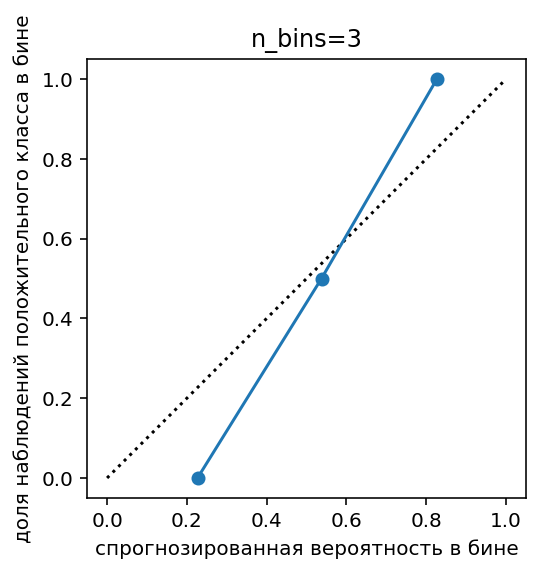

In [15]:
# строим график калибровки   
plot_calibration_curve(y_true, y_prob)
plt.title("n_bins=3")
plt.tight_layout()

In [16]:
# вычислим оценку Брайера с помощью функции brier_score_loss()
brier_score = brier_score_loss(y_true, y_prob)
brier_score

0.13826999999999998

In [17]:
# вычислим оценку Брайера вручную
manual_brier_score = (sum(np.square(y_true - y_prob))) / len(y_true)
manual_brier_score

0.13826999999999998

In [18]:
# загружаем данные
data = pd.read_csv('Data/Response.csv', sep=';')
data.head(3)

,mortgage,life_ins,cre_card,deb_card,mob_bank,curr_acc,internet,perloan,savings,atm_user,markpl,age,cus_leng,response
0,No,No,No,No,No,No,No,No,No,No,No,18.0,less than 3 years,No
1,Yes,Yes,NaN,NaN,Yes,No,NaN,NaN,NaN,Yes,No,18.0,NaN,Yes
2,Yes,Yes,NaN,Yes,No,No,No,No,No,No,Yes,NaN,from 3 to 7 years,Yes


In [19]:
# меняем строковые метки на целочисленные
data['response'] = np.where(data['response'] == 'Yes', 1, 0)

In [20]:
# разбиваем данные на обучающую и тестовую выборки
X_tr, X_tst, y_tr, y_tst = train_test_split(
    data.drop('response', axis=1), 
    data['response'], 
    test_size=0.3,
    stratify=data['response'],
    random_state=42)

In [21]:
# создаем списки категориальных 
# и количественных столбцов
cat_cols = X_tr.select_dtypes(
    include='object').columns.tolist()
num_cols = X_tr.select_dtypes(
    exclude='object').columns.tolist()

In [22]:
# создаем конвейер для количественных переменных
# (для применения с логистической регрессией)
logreg_num_pipe = Pipeline([
    ('imp', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

# создаем конвейер для количественных переменных
# (для применения с ансамблями на основе деревьев)
tree_num_pipe = Pipeline([
    ('imp', SimpleImputer(strategy='constant', 
                          fill_value=-999))
])

# создаем конвейер для категориальных переменных
cat_pipe = Pipeline([
    ('imp', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(sparse=False, 
                          handle_unknown='ignore'))
])

# создаем список трансформеров для логистической регрессии
logreg_transformers = [('num', logreg_num_pipe, num_cols), 
                       ('cat', cat_pipe, cat_cols)]
logreg_transformer = ColumnTransformer(
    transformers=logreg_transformers)

# создаем список трансформеров для ансамблей на основе деревьев
tree_transformers = [('num', tree_num_pipe, num_cols), 
                     ('cat', cat_pipe, cat_cols)]
tree_transformer = ColumnTransformer(
    transformers=tree_transformers)

# создаем итоговый конвейер для логистической регрессии
lr_pipe = Pipeline([
    ('logreg_tf', logreg_transformer), 
    ('lr', LogisticRegression(solver='liblinear'))
])

# создаем итоговый конвейер для градиентного бустинга
gb_pipe = Pipeline([
    ('tree_tf', tree_transformer), 
    ('gb', GradientBoostingClassifier(n_estimators=100, 
                                      random_state=42))
])

# создаем итоговый конвейер для случайного леса
rf_pipe = Pipeline([
    ('tree_tf', tree_transformer), 
    ('rf', RandomForestClassifier(n_estimators=100, 
                                  random_state=42))
])

# создаем итоговый конвейер для линейного SVM
svc_pipe = Pipeline([
    ('logreg_tf', logreg_transformer), 
    ('svc', LinearSVC())
])

In [23]:
# пишем функцию для построения графика калибровки и
# гистограммы распределения средних спрогнозированных
# значений по бинам
def extended_calibration_plot(X_train, X_test, y_train, y_test):
    # создаем таблицу графиков
    plt.figure(figsize=(9, 9))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax1.grid()
    ax2 = plt.subplot2grid((3, 1), (2, 0))
    ax2.grid()
    ax1.plot([0, 1], [0, 1], "k:", label="Идеальная калибровка")

    # обучаем конвейеры
    for pipe, name in [(lr_pipe, "Логистическая регрессия"),
                       (gb_pipe, "Обычный градиентный бустинг"),
                       (rf_pipe, "Случайный лес"),
                       (svc_pipe, "Линейный SVM")]:
        pipe.fit(X_train, y_train)
        
        # если объект имеет атрибут 'predict_proba'
        if hasattr(pipe, 'predict_proba'):
            # записываем вероятности положительного класса
            prob_pos = pipe.predict_proba(X_test)[:, 1]
        # если объект не имеет атрибут 'predict_proba'
        else:
            # используем решающую функцию
            prob_pos = pipe.decision_function(X_test)
            prob_pos = ((prob_pos - prob_pos.min()) / 
                        (prob_pos.max() - prob_pos.min()))
        
        # получаем фактические и спрогнозированные вероятности
        fraction_of_positives, mean_predicted_value = calibration_curve(
            y_test, prob_pos, n_bins=10)
        # строим график калибровки
        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s" % (name, ))
        # строим гистограмму
        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype='step', lw=2)
        
        # вычисляем оценку Брайера, AUC и логистическую функцию потерь
        brier_score = brier_score_loss(y_test, prob_pos)
        auc_score = roc_auc_score(y_test, prob_pos)
        log_loss_score = log_loss(y_test, prob_pos)
        # печатаем название метода, оценку Брайера, AUC 
        # и логистическую функцию потерь
        print("%s:" % name)
        print("\tОценка Брайера: %1.3f" % (brier_score))
        print("\tAUC: %1.3f" % (auc_score))
        print("\tЛогистическая функция потерь: %1.3f" % (log_loss_score))
    
    # задаем заголовок оси y
    ax1.set_ylabel("Доля наблюдений положительного класса")
    # задаем диапазон значений оси y
    ax1.set_ylim([-0.05, 1.05])
    # задаем расположение легенды
    ax1.legend(loc="lower right")
    # задаем заголовок графика
    ax1.set_title("График калибровки (кривая надежности) и гистограмма")
    # задаем заголовок оси x
    ax2.set_xlabel("Усредненное спрогнозированное значение")
    # задаем заголовок оси y
    ax2.set_ylabel("Частота")
    # задаем расположение легенды
    ax2.legend(loc="upper center", ncol=2)
    # выполняем укладку
    plt.tight_layout()

Логистическая регрессия:
	Оценка Брайера: 0.123
	AUC: 0.907
	Логистическая функция потерь: 0.380
Обычный градиентный бустинг:
	Оценка Брайера: 0.120
	AUC: 0.911
	Логистическая функция потерь: 0.373
Случайный лес:
	Оценка Брайера: 0.152
	AUC: 0.873
	Логистическая функция потерь: 0.874
Линейный SVM:
	Оценка Брайера: 0.142
	AUC: 0.907
	Логистическая функция потерь: 0.441


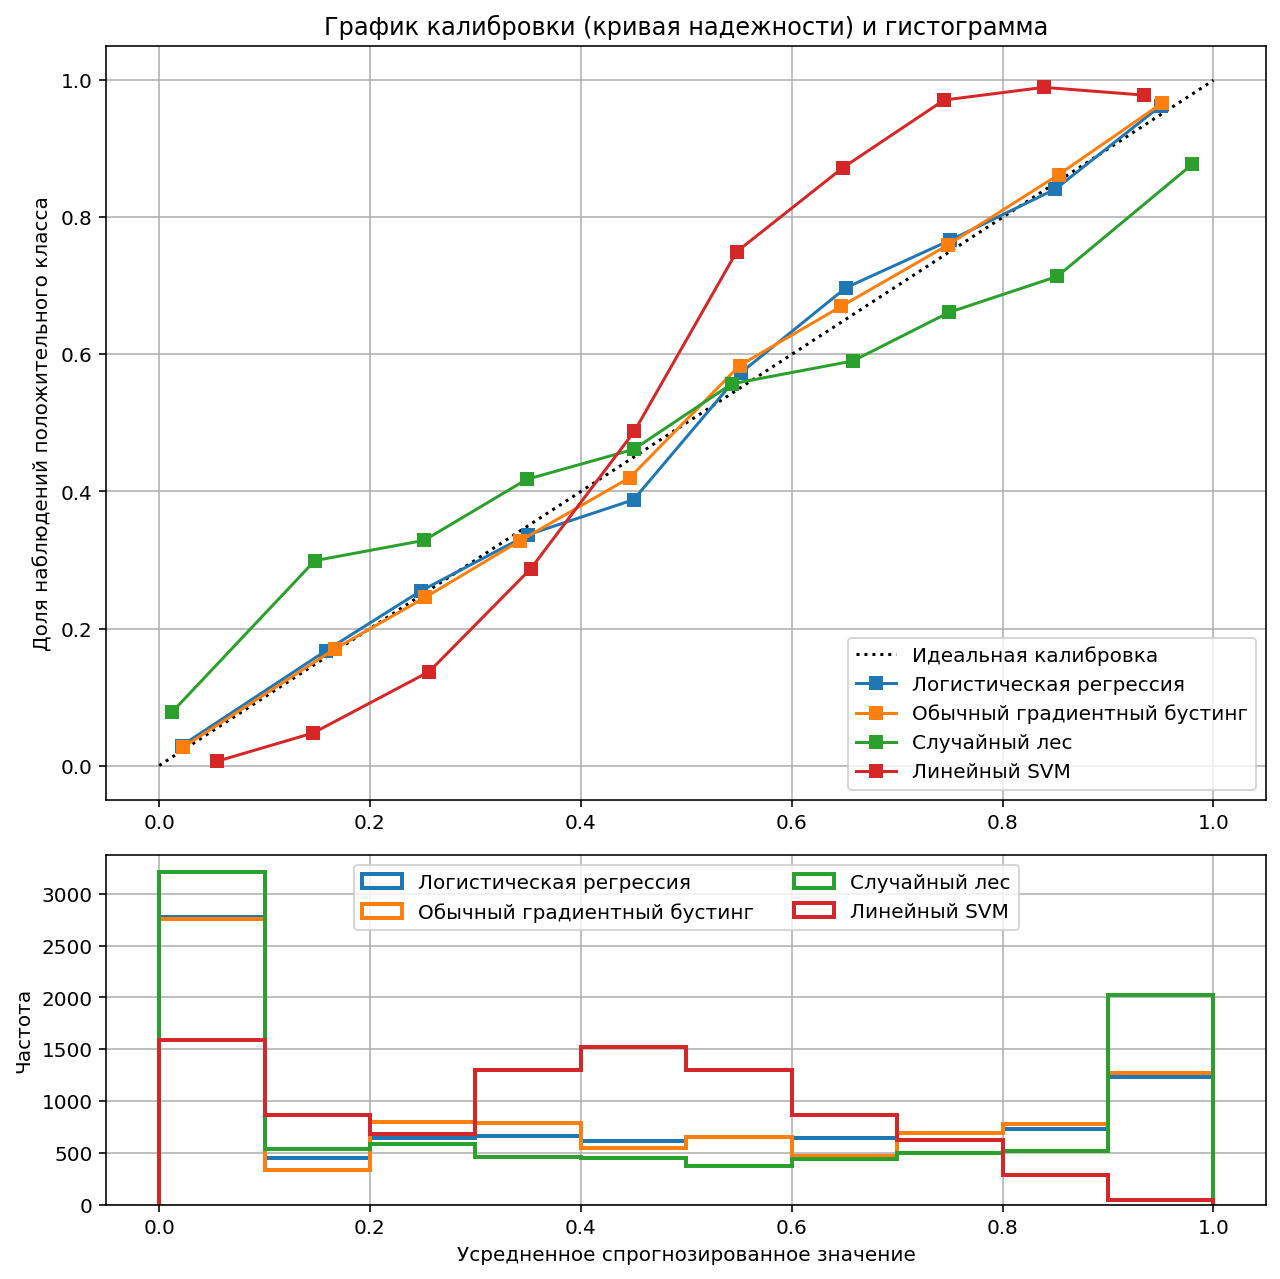

In [24]:
# применяем нашу функцию
extended_calibration_plot(X_tr, X_tst, y_tr, y_tst)

In [25]:
# создаем итоговый конвейер для логистической регрессии
lr_pipe = Pipeline([
    ('logreg_tf', logreg_transformer), 
    ('lr', CalibratedClassifierCV(
        LogisticRegression(solver='liblinear'), cv=10))
])

# создаем итоговый конвейер для градиентного бустинга
gb_pipe = Pipeline([
    ('tree_tf', tree_transformer), 
    ('gb', CalibratedClassifierCV(GradientBoostingClassifier(
        n_estimators=100, random_state=42), cv=10))
])

# создаем итоговый конвейер для случайного леса
rf_pipe = Pipeline([
    ('tree_tf', tree_transformer),
    ('rf', CalibratedClassifierCV(RandomForestClassifier(
        n_estimators=100, random_state=42), cv=10))
])

# создаем итоговый конвейер для линейного SVM
svc_pipe = Pipeline([
    ('logreg_tf', logreg_transformer),
    ('svc', CalibratedClassifierCV(LinearSVC(), cv=10))
])

Логистическая регрессия:
	Оценка Брайера: 0.123
	AUC: 0.907
	Логистическая функция потерь: 0.380
Обычный градиентный бустинг:
	Оценка Брайера: 0.120
	AUC: 0.911
	Логистическая функция потерь: 0.372
Случайный лес:
	Оценка Брайера: 0.145
	AUC: 0.878
	Логистическая функция потерь: 0.451
Линейный SVM:
	Оценка Брайера: 0.123
	AUC: 0.907
	Логистическая функция потерь: 0.381


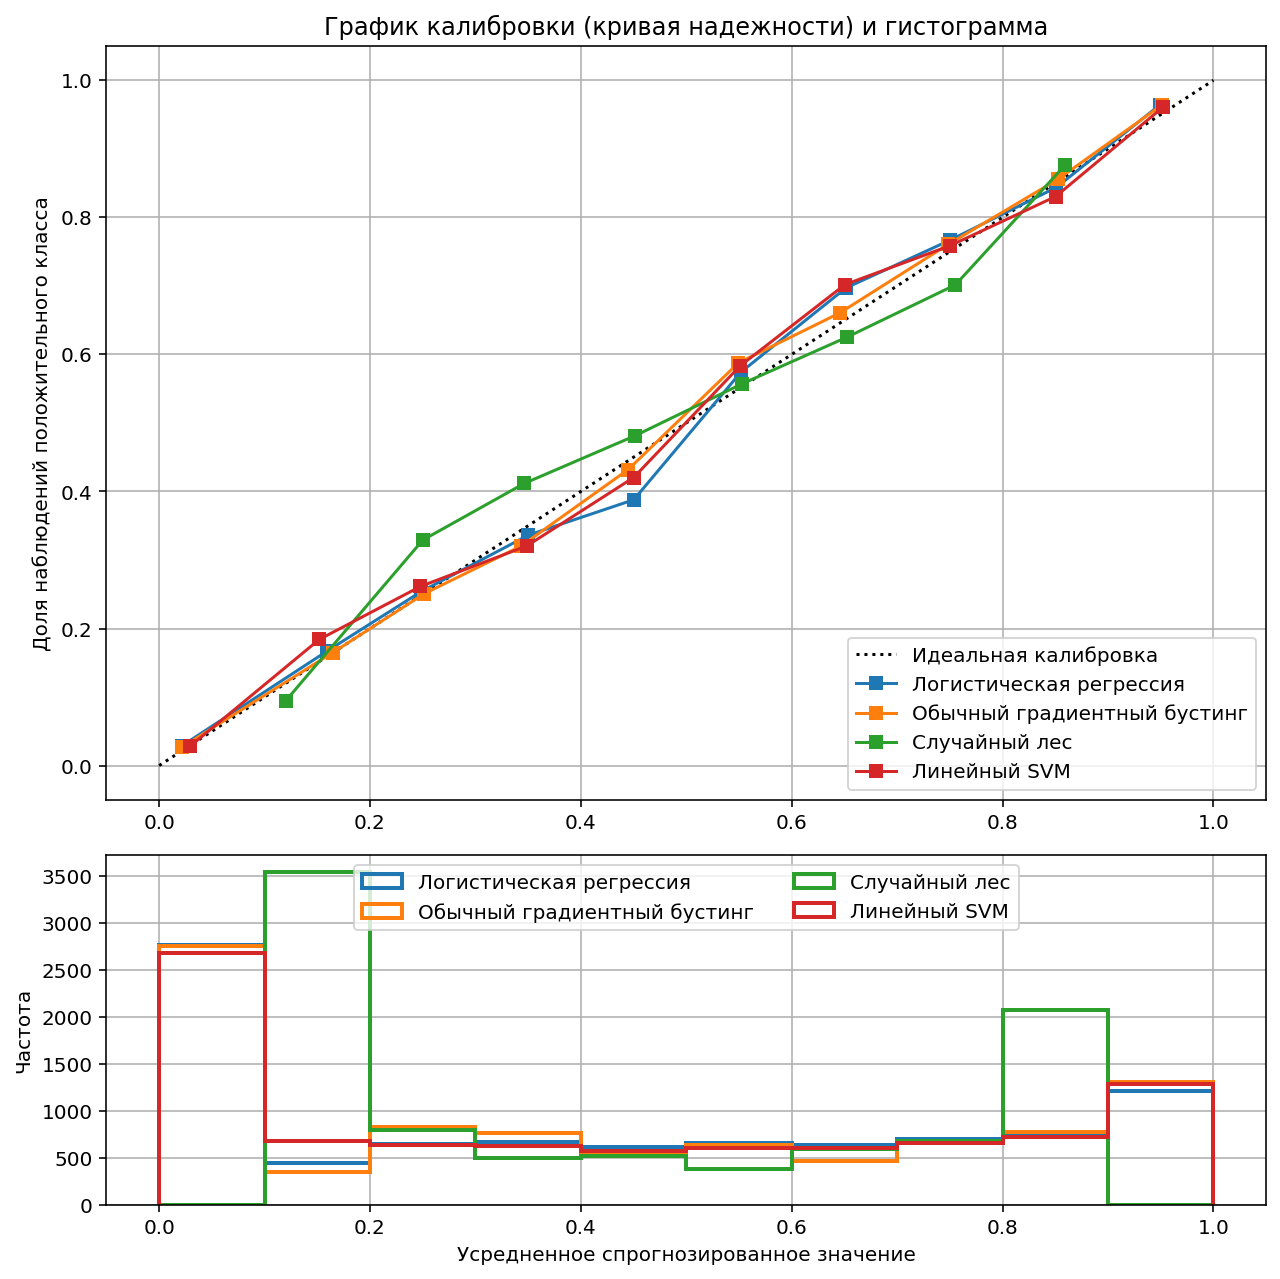

In [26]:
# вновь строим график калибровки и гистограмму распределения 
# средних спрогнозированных значений по бинам
extended_calibration_plot(X_tr, X_tst, y_tr, y_tst)

In [27]:
# разбиваем обучающую выборку на обучающую и проверочную
X_tr_sub, X_val, y_tr_sub, y_val = train_test_split(
    X_tr, y_tr,
    stratify=y_tr,
    random_state=42)

In [28]:
# печатаем информацию о пропусках
print(X_tr_sub.isnull().sum().sum())
print(X_val.isnull().sum().sum())
print(X_tst.isnull().sum().sum())

61
36
122


In [29]:
# печатаем размеры выборок
print(X_tr_sub.shape)
print(X_val.shape)
print(X_tst.shape)

(15885, 13)
(5296, 13)
(9078, 13)


In [30]:
# выполняем импутацию переменных
imp = SimpleImputer(strategy='mean')
imp.fit(X_tr_sub[num_cols])
X_tr_sub[num_cols] = imp.transform(X_tr_sub[num_cols])
X_val[num_cols] = imp.transform(X_val[num_cols])
X_tst[num_cols] = imp.transform(X_tst[num_cols])

imp2 = SimpleImputer(strategy='most_frequent')
imp2.fit(X_tr[cat_cols])
X_tr_sub[cat_cols] = imp2.transform(X_tr_sub[cat_cols])
X_val[cat_cols] = imp2.transform(X_val[cat_cols])
X_tst[cat_cols] = imp2.transform(X_tst[cat_cols])

# выполняем дамми-кодирование
X_tr_sub = pd.get_dummies(X_tr_sub)
X_val = pd.get_dummies(X_val)
X_tst = pd.get_dummies(X_tst)

# печатаем размеры выборок
print(X_tr_sub.shape)
print(X_val.shape)
print(X_tst.shape)

(15885, 26)
(5296, 26)
(9078, 26)


In [31]:
# обучаем случайный лес на обучающей выборке
rf = RandomForestClassifier(n_estimators=100, random_state=42).fit(
    X_tr_sub, y_tr_sub)
# вычисляем вероятности для тестовой выборки
scores = rf.predict_proba(X_tst)[:, 1]

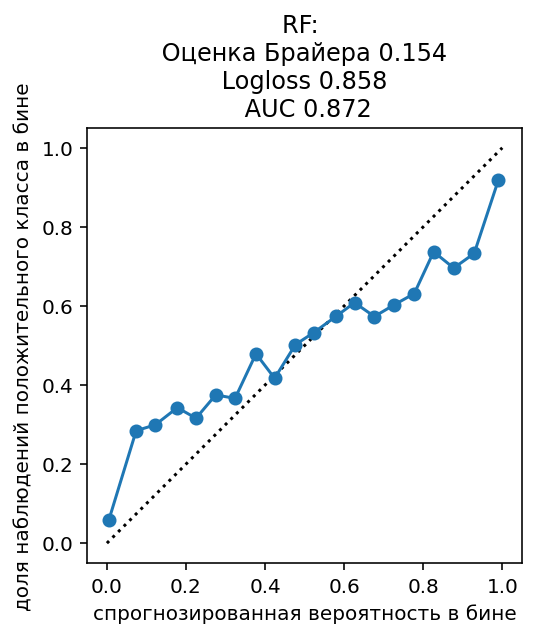

In [32]:
# построим график калибровки для вероятностей на 
# тестовой выборке и вычисляем логистическую
# функцию потерь, оценку Брайера и AUC
plot_calibration_curve(y_tst, scores, n_bins=20)
string = "{}: \n Оценка Брайера {:.3f} \n Logloss {:.3f} \n AUC {:.3f}"
plot = plt.title(string.format("RF",
                               brier_score_loss(y_tst, scores),
                               log_loss(y_tst, scores),
                               roc_auc_score(y_tst, scores)))

In [33]:
# создаем экземпляр класса CalibratedClassifierCV, передав уже
# обученную модель случайного леса и применив сигмоидную калибровку
cal_rf_sigm = CalibratedClassifierCV(rf, cv='prefit', method='sigmoid')
# обучаем калибратор на калибровочной выборке
cal_rf_sigm.fit(X_val, y_val)
# вычисляем с помощью калибратора вероятности на тестовой выборке 
scores_sigm = cal_rf_sigm.predict_proba(X_tst)[:, 1]

# создаем экземпляр класса CalibratedClassifierCV, передав уже
# обученную модель случайного леса и применив изотоническую калибровку
cal_rf_iso = CalibratedClassifierCV(rf, cv='prefit', method='isotonic')
# обучаем калибратор на калибровочной выборке
cal_rf_iso.fit(X_val, y_val)
# вычисляем с помощью калибратора вероятности на тестовой выборке 
scores_iso = cal_rf_iso.predict_proba(X_tst)[:, 1]

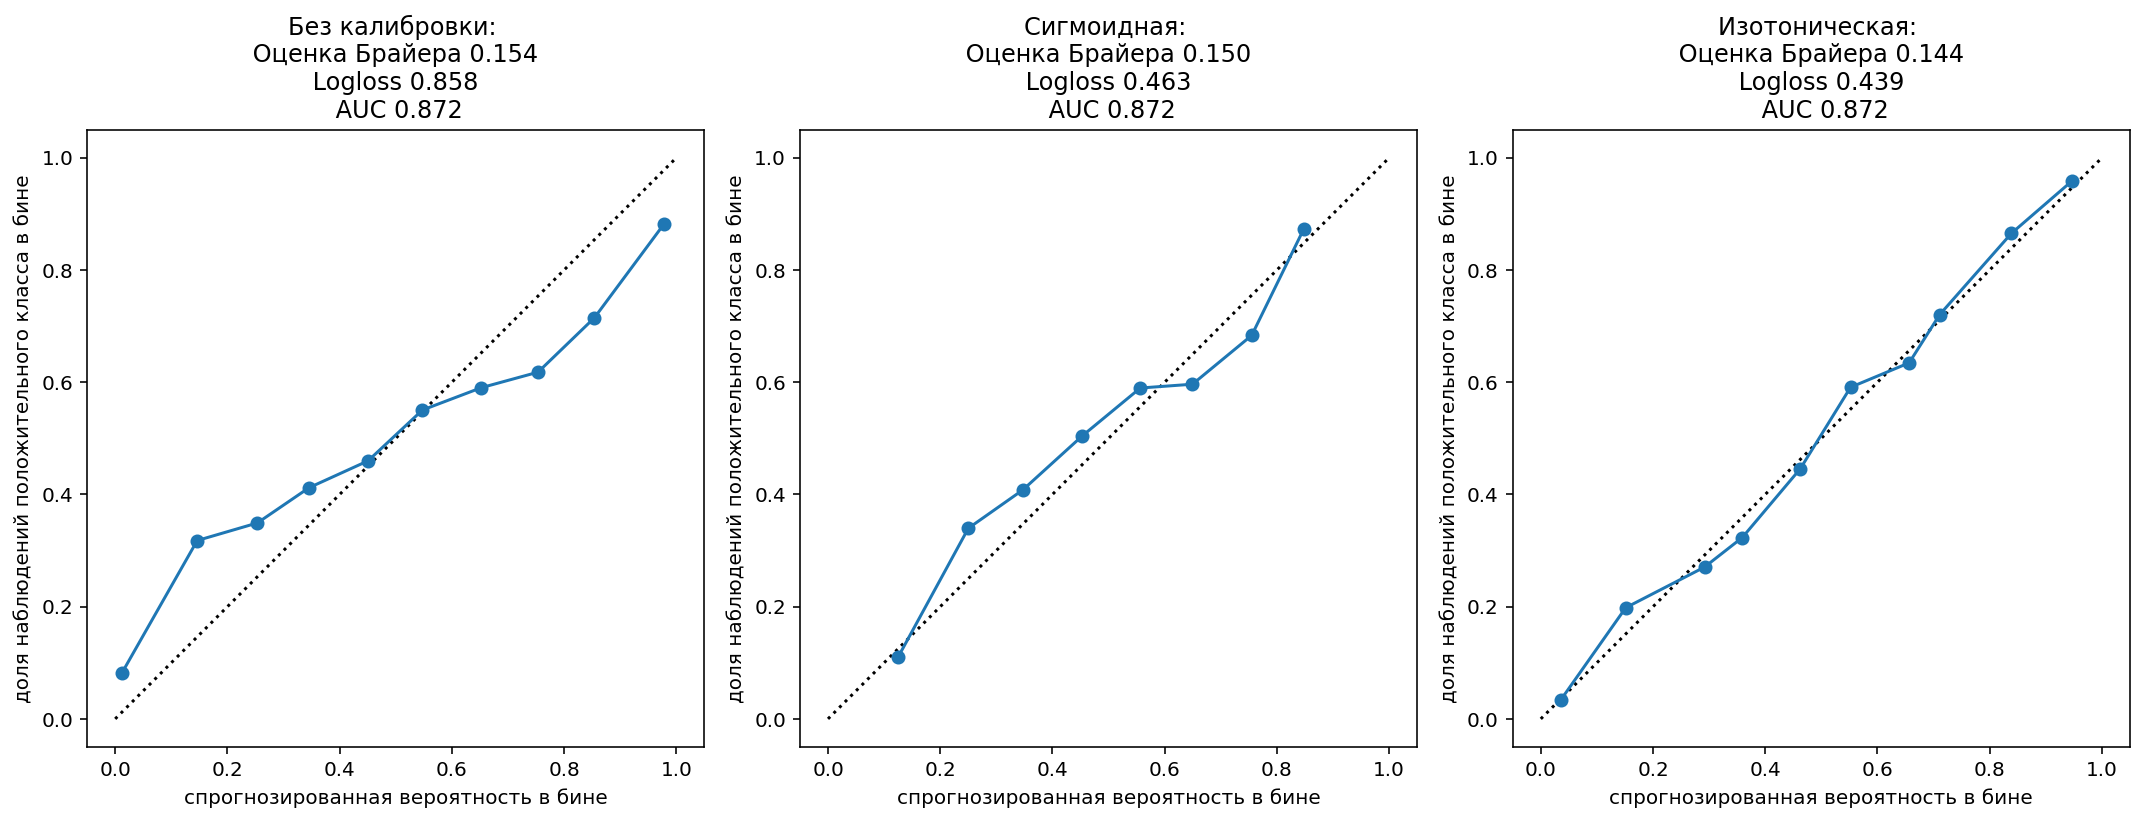

In [34]:
# выводим графики калибровки и оценки метрик для случая без 
# калибровки, калибровки Платта и изотонической регрессии
fig, axes = plt.subplots(1, 3, figsize=(15, 15))

for name, s, ax in zip(["Без калибровки", "Сигмоидная", "Изотоническая"],
                       [scores, scores_sigm, scores_iso], axes):
    plot_calibration_curve(y_tst, s, n_bins=10, ax=ax)
    ax.set_title(string.format(name, 
                               brier_score_loss(y_tst, s),
                               log_loss(y_tst, s),
                               roc_auc_score(y_tst, s)))
plt.tight_layout()

In [35]:
# создаем экземпляр класса SplineCalibratedClassifierCV, передав уже
# обученную модель случайного леса и применив метод ridge
cal_rf_spline_ridge = SplineCalibratedClassifierCV(
    base_estimator=rf, 
    cv='prefit',
    transform_type='none',
    method='ridge')
# обучаем калибратор на калибровочной выборке
cal_rf_spline_ridge.fit(X_val, y_val)
# вычисляем с помощью калибратора 
# вероятности на тестовой выборке 
scores_spline_ridge = cal_rf_spline_ridge.predict_proba(X_tst)[:, 1]

Determining Calibration Function
Originally there were 1651 knots.  Reducing to 225 while preserving first and last knot.
Trying 71 values of alpha between 1e-07 and 10000000.0
Best value found alpha = 0.06309573444801943


In [36]:
# создаем экземпляр класса SplineCalibratedClassifierCV, передав уже
# обученную модель случайного леса и применив метод logistic
cal_rf_spline_logistic = SplineCalibratedClassifierCV(
    base_estimator=rf, 
    cv='prefit',
    transform_type='none',
    method='logistic')
# обучаем калибратор на калибровочной выборке
cal_rf_spline_logistic.fit(X_val, y_val)
# вычисляем с помощью калибратора 
# вероятности на тестовой выборке 
scores_spline_logistic = cal_rf_spline_logistic.predict_proba(X_tst)[:, 1]

Determining Calibration Function
Originally there were 1651 knots.  Reducing to 225 while preserving first and last knot.
Trying 61 values of C between 1e-07 and 100000.0
Best value found C = [10000.]


In [37]:
# создаем экземпляр класса SplineCalibratedClassifierCV, передав уже
# обученную модель случайного леса, применив метод logistic
# и преобразование с помощью компактного логита
cal_rf_spline_logistic_cl = SplineCalibratedClassifierCV(
    base_estimator=rf, 
    cv='prefit',
    transform_type='cl',
    method='logistic')
# обучаем калибратор на калибровочной выборке
cal_rf_spline_logistic_cl.fit(X_val, y_val)
# вычисляем с помощью калибратора 
# вероятности на тестовой выборке 
scores_spline_logistic_cl = cal_rf_spline_logistic_cl.predict_proba(
    X_tst)[:, 1]

Determining Calibration Function
Originally there were 1642 knots.  Reducing to 224 while preserving first and last knot.
Trying 61 values of C between 1e-07 and 100000.0
Best value found C = [25118.8643151]


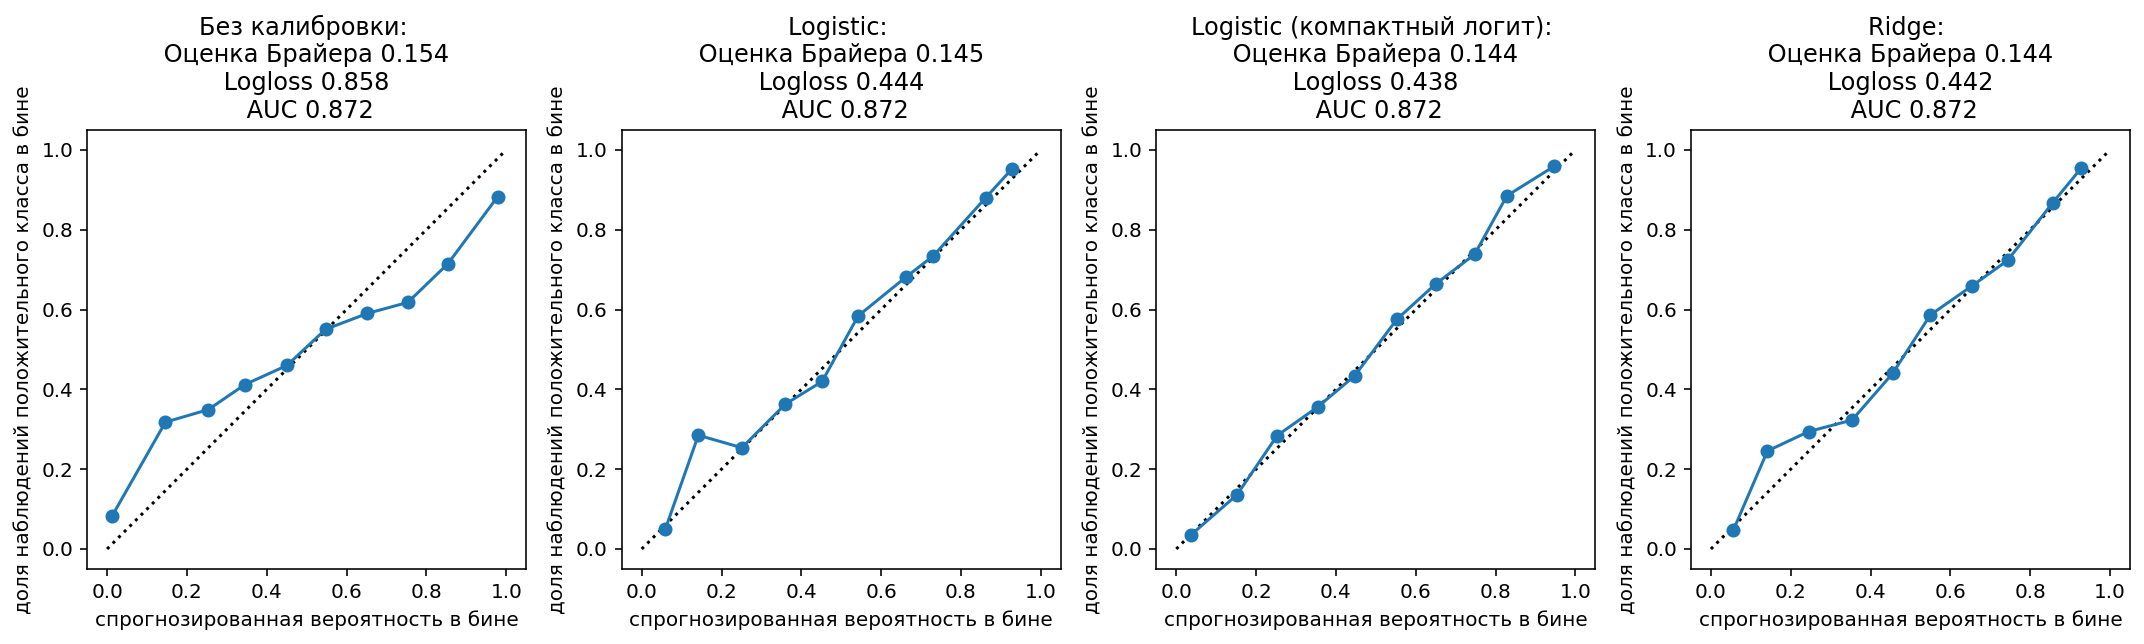

In [38]:
# выводим графики калибровки и оценки метрик для 
# трех способов калибровки на сплайнах
fig, axes = plt.subplots(1, 4, figsize=(15, 15))

for name, s, ax in zip(["Без калибровки", "Logistic", 
                        "Logistic (компактный логит)", "Ridge"],
                       [scores, scores_spline_logistic, 
                        scores_spline_logistic_cl, 
                        scores_spline_ridge], axes):
    plot_calibration_curve(y_tst, s, n_bins=10, ax=ax)
    ax.set_title(string.format(name, 
                               brier_score_loss(y_tst, s),
                               log_loss(y_tst, s),
                               roc_auc_score(y_tst, s)))
plt.tight_layout()

In [39]:
# из исходной выборки удаляем наблюдения с пропусками
data.dropna(inplace=True)

# разбиваем данные на обучающую и тестовую выборки
X_tr, X_tst, y_tr, y_tst = train_test_split(
    data.drop('response', axis=1), 
    data['response'], 
    test_size=0.3,
    stratify=data['response'],
    random_state=42)

# печатаем размеры выборок
print(X_tr.shape)
print(X_tst.shape)

(21153, 13)
(9066, 13)


In [40]:
# выполняем дамми-кодирование
X_tr = pd.get_dummies(X_tr)
X_tst = pd.get_dummies(X_tst)

# печатаем размеры выборок
print(X_tr.shape)
print(X_tst.shape)

(21153, 26)
(9066, 26)


In [41]:
# обучаем случайный лес на обучающей выборке
rf = RandomForestClassifier(n_estimators=100, random_state=42).fit(
    X_tr, y_tr)
# вычисляем вероятности для тестовой выборки
scores = rf.predict_proba(X_tst)[:, 1]

In [42]:
# создаем экземпляр класса SplineCalibratedClassifierCV, 
# задав перекрестную проверку и применив метод ridge
cal_rf_spline_ridge = SplineCalibratedClassifierCV(
    base_estimator=rf,
    cv=5,
    transform_type='none',
    method='ridge')
# обучаем модель и выполняем калибровку
cal_rf_spline_ridge.fit(X_tr, y_tr)
# вычисляем с помощью калибратора 
# вероятности на тестовой выборке 
scores_spline_ridge = cal_rf_spline_ridge.predict_proba(X_tst)[:, 1]

training fold 1 of 5
training fold 2 of 5
training fold 3 of 5
training fold 4 of 5
training fold 5 of 5
Training Full Model
Determining Calibration Function
Originally there were 6114 knots.  Reducing to 226 while preserving first and last knot.
Trying 71 values of alpha between 1e-07 and 10000000.0
Best value found alpha = 0.00039810717055349735


In [43]:
# создаем экземпляр класса SplineCalibratedClassifierCV,
# задав перекрестную проверку и применив метод logistic
cal_rf_spline_logistic = SplineCalibratedClassifierCV(
    base_estimator=rf, 
    cv=5,
    transform_type='none',
    method='logistic')
# обучаем модель и выполняем калибровку
cal_rf_spline_logistic.fit(X_tr, y_tr)
# вычисляем с помощью калибратора 
# вероятности на тестовой выборке 
scores_spline_logistic = cal_rf_spline_logistic.predict_proba(X_tst)[:, 1]

training fold 1 of 5
training fold 2 of 5
training fold 3 of 5
training fold 4 of 5
training fold 5 of 5
Training Full Model
Determining Calibration Function
Originally there were 6114 knots.  Reducing to 226 while preserving first and last knot.
Trying 61 values of C between 1e-07 and 100000.0
Best value found C = [25118.8643151]


In [44]:
# создаем экземпляр класса SplineCalibratedClassifierCV,
# задав перекрестную проверку, применив метод logistic
# и преобразование с помощью компактного логита
cal_rf_spline_logistic_cl = SplineCalibratedClassifierCV(
    base_estimator=rf, 
    cv=5,
    transform_type='cl',
    method='logistic')
# обучаем модель и выполняем калибровку
cal_rf_spline_logistic_cl.fit(X_tr, y_tr)
# вычисляем с помощью калибратора 
# вероятности на тестовой выборке 
scores_spline_logistic_cl = cal_rf_spline_logistic_cl.predict_proba(
    X_tst)[:, 1]

training fold 1 of 5
training fold 2 of 5
training fold 3 of 5
training fold 4 of 5
training fold 5 of 5
Training Full Model
Determining Calibration Function
Originally there were 5907 knots.  Reducing to 225 while preserving first and last knot.
Trying 61 values of C between 1e-07 and 100000.0
Best value found C = [100000.]


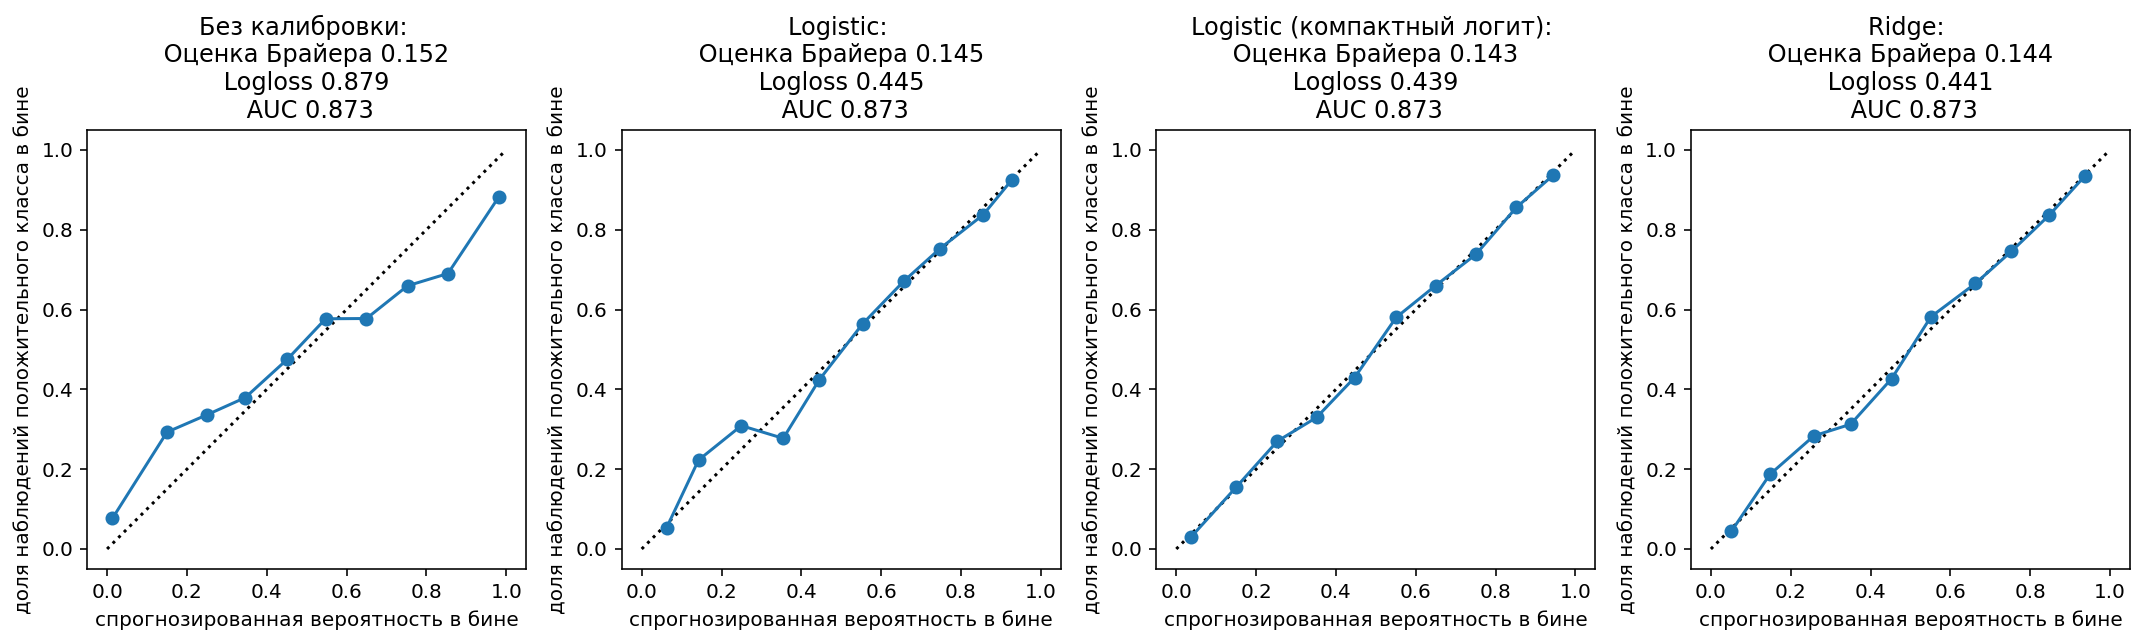

In [45]:
# выводим графики калибровки и оценки метрик для 
# трех способов калибровки на сплайнах
fig, axes = plt.subplots(1, 4, figsize=(15, 15))

for name, s, ax in zip(["Без калибровки", "Logistic", 
                        "Logistic (компактный логит)", "Ridge"],
                       [scores, scores_spline_logistic, 
                        scores_spline_logistic_cl, 
                        scores_spline_ridge], axes):
    plot_calibration_curve(y_tst, s, n_bins=10, ax=ax)
    ax.set_title(string.format(name, 
                               brier_score_loss(y_tst, s),
                               log_loss(y_tst, s),
                               roc_auc_score(y_tst, s)))
plt.tight_layout()